# Differential evolution: extensive testing on toy problems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
from utils import (run_replicates, ecdf_norm_plotter)

import pints
import pints.toy
import pints.plot
from pints.functionaltests.differential_evolution \
    import (test_differential_evolution_on_two_dim_gaussian,
            test_differential_evolution_on_banana,
            test_differential_evolution_on_correlated_gaussian,
            test_differential_evolution_on_annulus)

# Two dimensional Gaussian

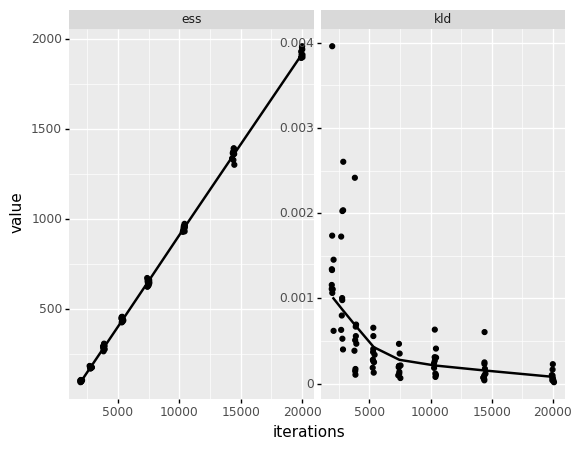

<ggplot: (8726135101531)>

In [3]:
low = np.log10(2000)
high = np.log10(20000)
test = run_replicates(10**np.linspace(low, high, 8), 10, test_differential_evolution_on_two_dim_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The ESS and KLD both trend in the correct directions.

In the next cell, we show the trace for an example run.

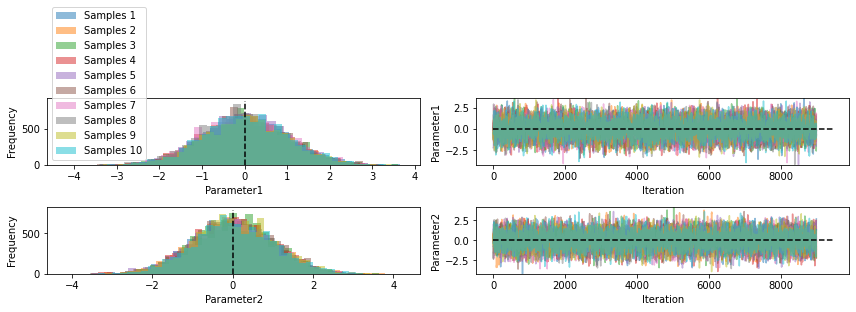

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  0.01    1.00    -1.94   -0.67  -0.00  0.69   2.02     1.00    8800.90  1919.88
param 2  0.01    1.01    -1.97   -0.67  0.00   0.70   1.98     1.00    8519.63  1858.53


In [4]:
n_chains = 10
n_iterations = 10000
n_warmup = 1000
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.DifferentialEvolutionMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

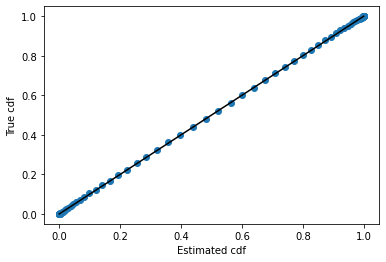

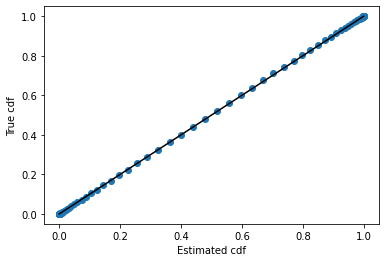

[None, None]

In [5]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

The parameter results and CDFs both look close to their true values.

# Correlated Gaussian

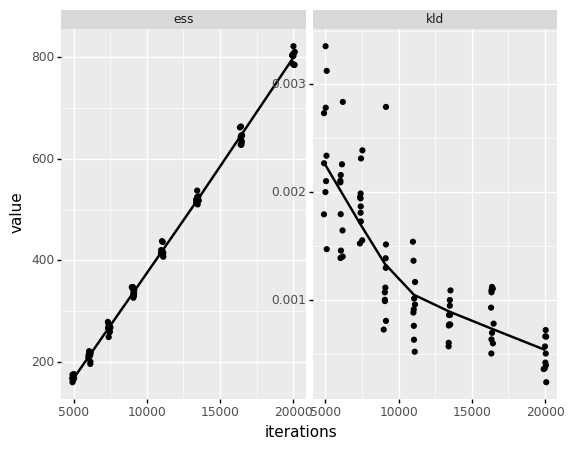

<ggplot: (8726132586996)>

In [7]:
low = np.log10(5000)
high = np.log10(20000)
test = run_replicates(10**np.linspace(low, high, 8), 10, test_differential_evolution_on_correlated_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

Example run of results.

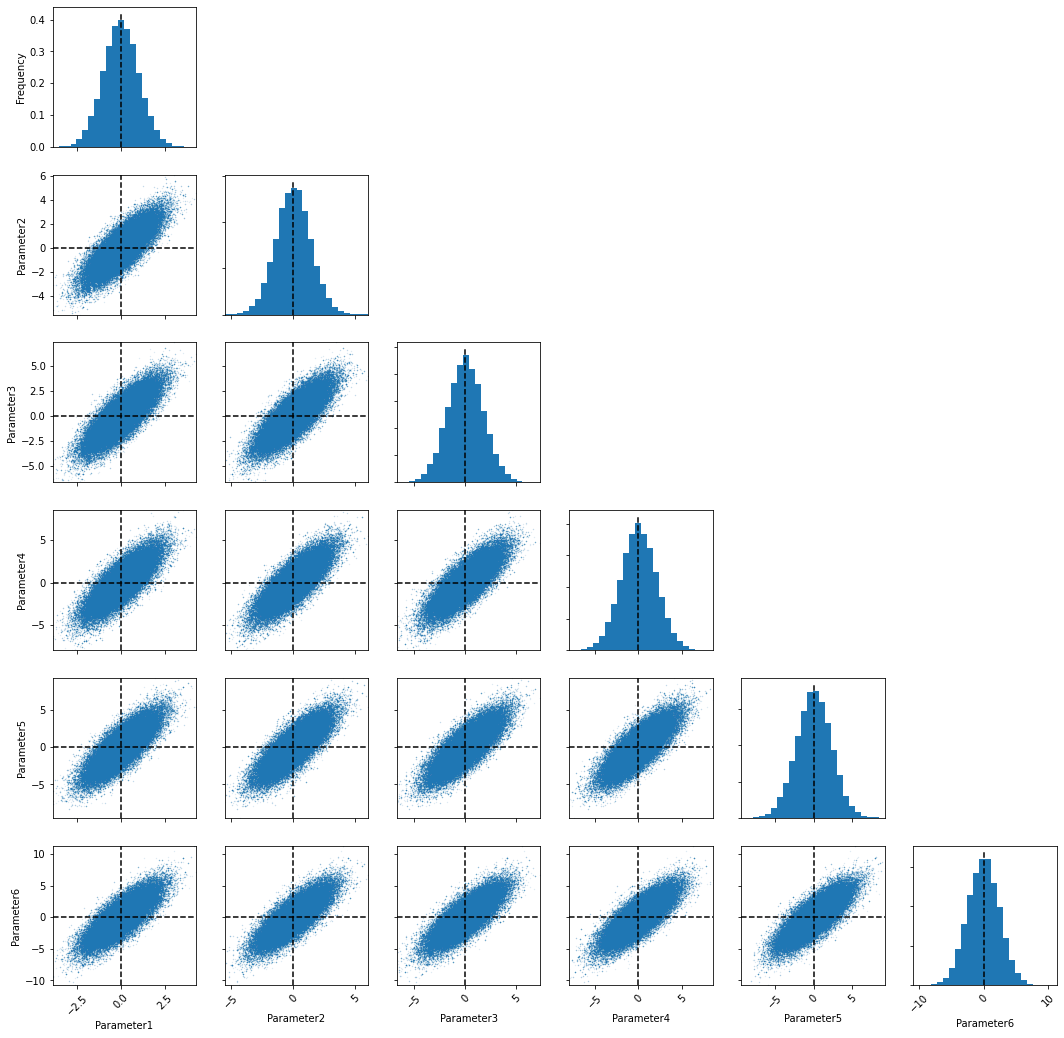

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  0.01    1.00    -1.96   -0.66  0.01   0.68   1.99     1.00    7548.95  948.72
param 2  0.01    1.42    -2.78   -0.93  0.02   0.97   2.80     1.00    7532.20  946.62
param 3  0.02    1.74    -3.42   -1.16  0.02   1.20   3.46     1.00    7632.65  959.24
param 4  0.04    2.02    -3.88   -1.31  0.04   1.41   4.01     1.00    7608.70  956.23
param 5  0.02    2.24    -4.42   -1.49  0.03   1.54   4.42     1.00    7800.97  980.40
param 6  0.05    2.44    -4.68   -1.61  0.07   1.70   4.86     1.00    7491.06  941.45


In [2]:
n_chains = 20
n_iterations = 10000
n_warmup = 1000

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.DifferentialEvolutionMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

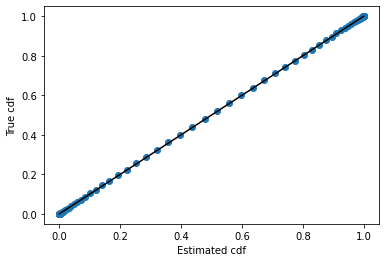

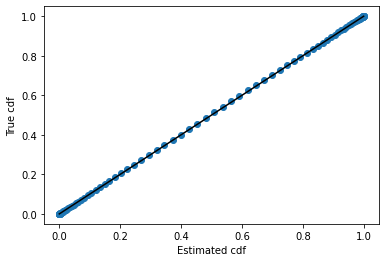

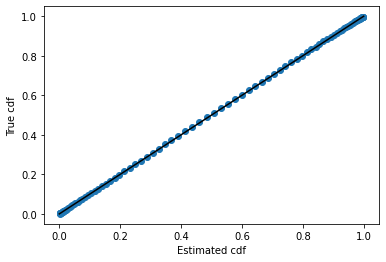

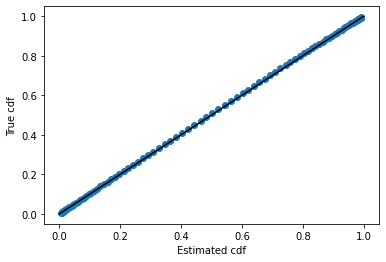

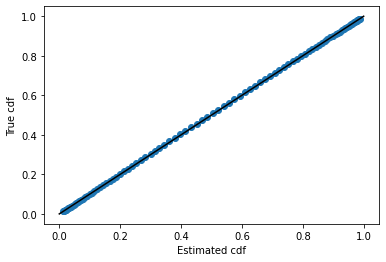

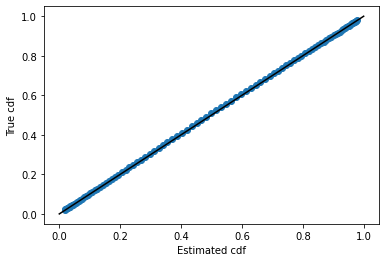

[None, None, None, None, None, None]

In [3]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

# Banana

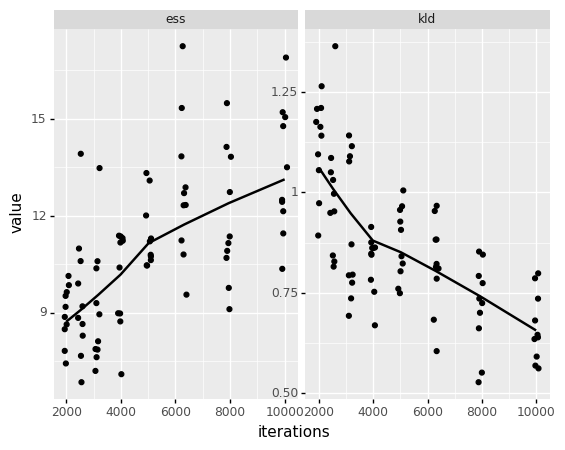

<ggplot: (8726134241540)>

In [4]:
low = np.log10(2000)
high = np.log10(10000)
test = run_replicates(10**np.linspace(low, high, 8), 10, test_differential_evolution_on_banana)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The banana is a hard problem.

Example run of results.

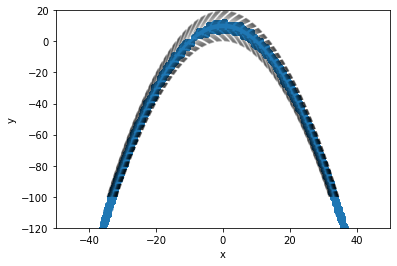

In [8]:
n_chains = 20
n_iterations = 10000
n_warmup = 1000

log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.1)
log_prior = pints.MultivariateGaussianLogPrior([0, 0],
                                               [[10, 0], [0, 10]])
x0 = log_prior.sample(n_chains)
sigma0 = np.diag(np.array([1, 3]))

levels = np.linspace(-50, -1, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.DifferentialEvolutionMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlim(-50, 50)
plt.ylim(-120, 20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [11]:
def run_replicates_annulus(iterations, n_replicates, test):
    df = pd.DataFrame(columns=['iterations', 'replicate', 'distance', 'ess'],
                      index=np.arange(len(iterations) * n_replicates))
    k = 0
    for it in iterations:
        for rep in range(n_replicates):
            result = test(it)
            df.iloc[k] = {'iterations': it, 'replicate': rep,
                          'distance': result['distance'], 'ess': result['mean-ess']}
            k += 1
    df['iterations'] = pd.to_numeric(df['iterations'])
    df['distance'] = pd.to_numeric(df['distance'])
    df['ess'] = pd.to_numeric(df['ess'])
    return df

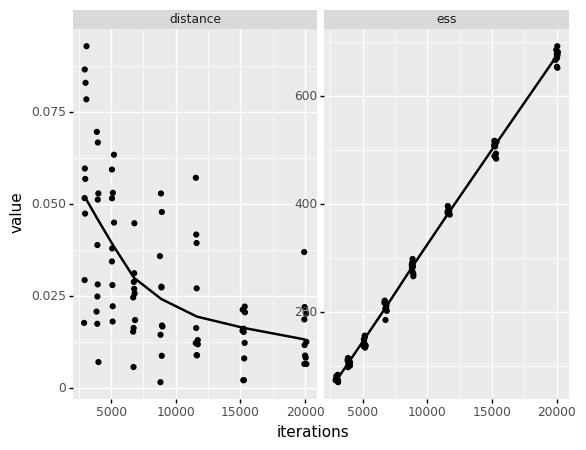

<ggplot: (8726133732789)>

In [12]:
low = np.log10(3000)
high = np.log10(20000)
test = run_replicates_annulus(10**np.linspace(low, high, 8), 10, test_differential_evolution_on_annulus)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

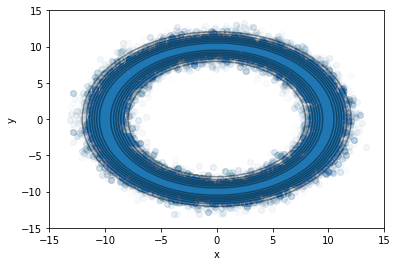

In [14]:
n_chains = 10
n_iterations = 10000
n_warmup = 1000

log_pdf = pints.toy.AnnulusLogPDF()
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.DifferentialEvolutionMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.4)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.01)
plt.xlabel('x')
plt.ylabel('y')
plt.show()